Notebook showing basic usage.

Helper for loading `api_key` and not displaying in notebook

In [1]:
import json
from PIL import Image, ImageDraw, ImageFont
from typing import Tuple

import simplehound.core as hound

def load_api_secrets(filename):
    """Convenience to load the API key from a json file."""
    try:
        with open(filename, 'r') as fp:
            api_params = json.load(fp)
    except Exception as e:
        print('Failed to load API secrets key: {}'.format(e))
        api_params = None
    return api_params['key']

In [2]:
api_key = load_api_secrets('/Users/robin/Documents/Sighthound_API_key.json')

## API usage

In [3]:
api = hound.cloud(api_key)

In [4]:
image_file_path = 'tests/images/people_car.jpg'

In [5]:
# image_file_path = 'tests/images/face.jpg' # test a face

In [6]:
# image_file_path = 'tests/images/balaclava.jpg' # person in balaclava

In [7]:
#image_file_path = 'tests/images/behind.jpg' # test people with no face

In [8]:
with open(image_file_path, "rb") as img_bytes:
    detections = api.detect(img_bytes.read())

In [9]:
detections

{'image': {'width': 960, 'height': 480, 'orientation': 1},
 'objects': [{'type': 'face',
   'boundingBox': {'x': 305, 'y': 151, 'height': 28, 'width': 30},
   'attributes': {'gender': 'male',
    'genderConfidence': 0.9733,
    'age': 33,
    'ageConfidence': 0.7801,
    'frontal': True}},
  {'type': 'face',
   'boundingBox': {'x': 855, 'y': 147, 'height': 29, 'width': 24},
   'attributes': {'gender': 'male',
    'genderConfidence': 0.9834,
    'age': 37,
    'ageConfidence': 0.5096,
    'frontal': False}},
  {'type': 'person',
   'boundingBox': {'x': 227, 'y': 133, 'height': 245, 'width': 125}},
  {'type': 'person',
   'boundingBox': {'x': 833, 'y': 137, 'height': 268, 'width': 93}}],
 'requestId': '545cec700eac4d389743e2266264e84b'}

In [10]:
metadata = hound.get_metadata(detections)
metadata

{'image_width': 960,
 'image_height': 480,
 'requestId': '545cec700eac4d389743e2266264e84b'}

In [11]:
faces = hound.get_faces(detections)
faces

[{'gender': 'male',
  'age': 33,
  'boundingBox': {'x': 305, 'y': 151, 'height': 28, 'width': 30}},
 {'gender': 'male',
  'age': 37,
  'boundingBox': {'x': 855, 'y': 147, 'height': 29, 'width': 24}}]

In [12]:
people = hound.get_people(detections)
people

[{'boundingBox': {'x': 227, 'y': 133, 'height': 245, 'width': 125}},
 {'boundingBox': {'x': 833, 'y': 137, 'height': 268, 'width': 93}}]

## Plot detections
We use a [helper function](https://github.com/home-assistant/home-assistant/blob/dev/homeassistant/components/image_processing/__init__.py) for displaying the bounding boxes:

In [13]:
def draw_box(
    draw: ImageDraw,
    box: Tuple[float, float, float, float],
    img_width: int,
    img_height: int,
    text: str = "",
    color: Tuple[int, int, int] = (255, 255, 0),
) -> None:
    """
    Draw a bounding box on and image.
    The bounding box is defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.
    For example, if an image is 100 x 200 pixels (height x width) and the bounding
    box is `(0.1, 0.2, 0.5, 0.9)`, the upper-left and bottom-right coordinates of
    the bounding box will be `(40, 10)` to `(180, 50)` (in (x,y) coordinates).
    """

    line_width = 3
    font_height = 8
    y_min, x_min, y_max, x_max = box
    (left, right, top, bottom) = (
        x_min * img_width,
        x_max * img_width,
        y_min * img_height,
        y_max * img_height,
    )
    draw.line(
        [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
        width=line_width,
        fill=color,
    )
    if text:
        draw.text(
            (left + line_width, abs(top - line_width - font_height)), text, fill=color
        )

In [14]:
img_width = metadata['image_width']
img_height = metadata['image_height']

In [15]:
tf_bbox = hound.bbox_to_tf_style(people[0]['boundingBox'], img_width, img_height)
tf_bbox

(0.27708, 0.23646, 0.7875, 0.36667)

In [16]:
for person in people:
    print(person['boundingBox'])
    print(hound.bbox_to_tf_style(person['boundingBox'], img_width, img_height))

{'x': 227, 'y': 133, 'height': 245, 'width': 125}
(0.27708, 0.23646, 0.7875, 0.36667)
{'x': 833, 'y': 137, 'height': 268, 'width': 93}
(0.28542, 0.86771, 0.84375, 0.96458)


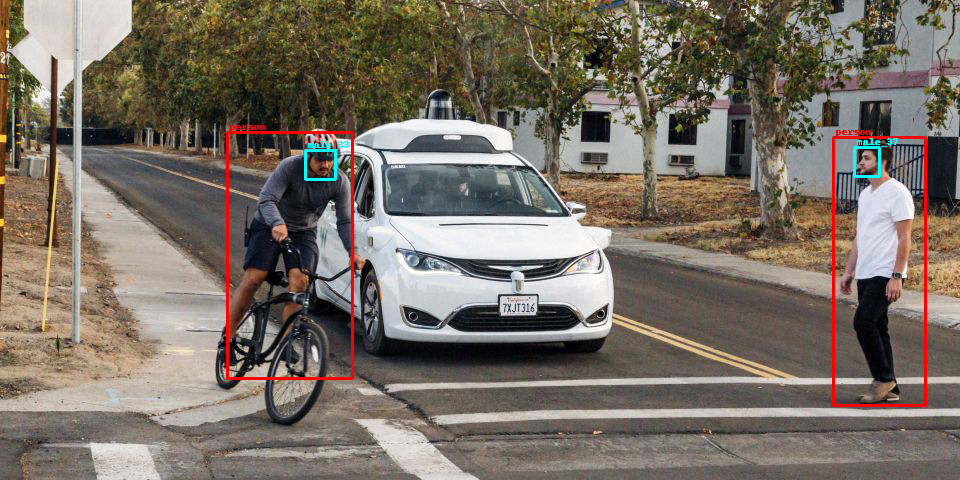

In [17]:
img = Image.open(image_file_path)
draw = ImageDraw.Draw(img)

red=(255, 0, 0)
yellow=(255, 255, 0)
blue=(0, 255, 255)

for person in people:
    bbox = hound.bbox_to_tf_style(person['boundingBox'], img_width, img_height)
    draw_box(draw, bbox, img_width, img_height, text="person", color=red)

for face in faces:
    age = str(face['age'])
    gender = face['gender']
    face_description = f"{gender}_{age}"
    bbox = hound.bbox_to_tf_style(face['boundingBox'], img_width, img_height)
    draw_box(draw, bbox, img_width, img_height, text=face_description, color=blue)

img